In this notebook, I tried transfer learning using Efficientnet as my base model. 
But it didn't produce a good result.
So I retrained all the weights in the Efficientnet using my `NEW4_image_transfer_trial4` data.


In [1]:
# Kaggle: Recursion Cellular Image Classification
# https://www.kaggle.com/leighplt/densenet121-pytorch
# https://stackoverflow.com/questions/43264816/need-help-combining-two-3-channel-images-into-6-channel-image-python
# https://www.pyimagesearch.com/2019/06/24/change-input-shape-dimensions-for-fine-tuning-with-keras/
# https://github.com/keras-team/keras/issues/4664
# https://www.machinecurve.com/index.php/2019/10/18/a-simple-conv3d-example-with-keras/

# Efficientnet
# https://www.dlology.com/blog/transfer-learning-with-efficientnet/
# https://github.com/titu1994/keras-efficientnets

import os
import numpy as np
np.random.seed(251)
os.environ['PYTHONHASHSEED']=str(251)
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import class_weight
from keras_efficientnets import EfficientNetB0

Using TensorFlow backend.


In [2]:
project_path = r'D:\UCBerkeley\CourseWork\202001\W251\Homework\Project'
dir_openpose = 'openpose_output'
dir_train = 'NEW4_image_transfer_trial3'
dir_test = 'NEW4_manual_optical_flow_output_trial3'
model_name = 'Efficientnet_model_weights_NEW4_trial3.h5'

TRAIN_DIR = os.path.join(project_path, dir_openpose, dir_train)
# class_list = ['AGAIN', 'ALL', 'AWKWARD', 'BASEBALL', 'BEHAVIOR', 'CAN', 'CHAT', 'CHEAP', 
#               'CHEAT', 'CHURCH', 'COAT', 'CONFLICT', 'COURT', 'DEPOSIT', 'DEPRESS', 
#               'DOCTOR', 'DRESS', 'ENOUGH', 'NEG']
y_train_lst = [f.split('_')[1] for f in os.listdir(os.path.join(project_path, dir_openpose, dir_test)) if 'train' in f]
class_list = np.unique(y_train_lst)
sample_class_weights = class_weight.compute_class_weight('balanced', class_list, y_train_lst)

HEIGHT = 224
WIDTH = 224

BATCH_SIZE = 16
NUM_EPOCHS = 10
num_train_images = len([f for f in os.listdir(os.path.join(project_path, dir_openpose, dir_test)) 
                        if 'train' in f])
print(num_train_images)

1155


In [3]:
# Reference: https://keras.io/preprocessing/image/
# Reference: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
train_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    # Below are the parameters used for crop
    # zoom_range=[0.8, 1.2], 
    # width_shift_range=[-50,50]
    # Below are the parameters used for no crop
    zoom_range=[0.7, 1.3], 
    # width shift means up and down
    width_shift_range=0.2,
    height_shift_range = 0.2
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)
base_model = EfficientNetB0(input_shape=(HEIGHT, WIDTH, 3), include_top=False, weights='imagenet')
# base_model = ResNet50(weights='imagenet', 
#                       include_top=False, 
#                       input_shape=(HEIGHT, WIDTH, 3))
base_output = base_model.layers[-1].output
# base_output = base_model.layers[5].output
# base_output = Flatten()(base_output)
base_model = Model(base_model.input, output=base_output)

# for layer in base_model.layers:
#     layer.trainable = False
    
# base_model.trainable = True
# set_trainable = False
# for layer in base_model.layers:
#     if layer.name in ['conv2d_64', 'batch_normalization_48', 'conv2d_65', 'batch_normalization_49']:
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False
#         
# layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]
# pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']).tail(10)

Found 1155 images belonging to 19 classes.


C:\Users\Angela\Anaconda3\envs\w251_project3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("sw...)`


In [4]:
base_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 112, 112, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [5]:
# test_config = base_model.get_layer('dropout_6').get_config()
# test_config['batch_input_shape'] = (None, 300, 300, 6)

In [6]:
model = Sequential()
model.add(base_model)
# GlobalAveragePooling2D is what the original efficientnet uses
model.add(GlobalAveragePooling2D(name="gap"))
# Dropout rate of 0.2 is what the original efficientnet uses
model.add(Dropout(0.2))
model.add(Dense(len(class_list), activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.00001),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 7, 7, 1280)        4049564   
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 19)                24339     
Total params: 4,073,903
Trainable params: 4,031,887
Non-trainable params: 42,016
_________________________________________________________________


In [7]:
filepath=os.path.join(project_path, model_name)
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]
history = model.fit_generator(train_generator, epochs=NUM_EPOCHS, 
                              steps_per_epoch=num_train_images // BATCH_SIZE, 
                              shuffle=True, 
                              class_weight=dict(enumerate(sample_class_weights)), 
                              callbacks=callbacks_list)

Epoch 1/10
72/72 [==============================] - 211s 3s/step - loss: 2.9810 - accuracy: 0.0632

Epoch 00001: saving model to D:\UCBerkeley\CourseWork\202001\W251\Homework\Project\Efficientnet_model_weights_NEW4_trial3.h5
Epoch 2/10
72/72 [==============================] - 203s 3s/step - loss: 2.8258 - accuracy: 0.1176

Epoch 00002: saving model to D:\UCBerkeley\CourseWork\202001\W251\Homework\Project\Efficientnet_model_weights_NEW4_trial3.h5
Epoch 3/10
72/72 [==============================] - 206s 3s/step - loss: 2.6869 - accuracy: 0.1814

Epoch 00003: saving model to D:\UCBerkeley\CourseWork\202001\W251\Homework\Project\Efficientnet_model_weights_NEW4_trial3.h5
Epoch 4/10
72/72 [==============================] - 200s 3s/step - loss: 2.5574 - accuracy: 0.2709

Epoch 00004: saving model to D:\UCBerkeley\CourseWork\202001\W251\Homework\Project\Efficientnet_model_weights_NEW4_trial3.h5
Epoch 5/10
72/72 [==============================] - 203s 3s/step - loss: 2.4519 - accuracy: 0.3178



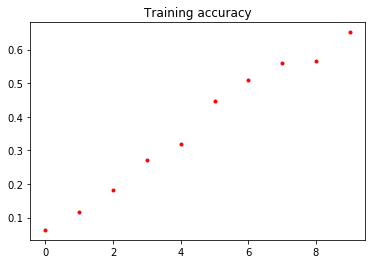

In [8]:
# Plot the training and validation loss + accuracy
def plot_training(history):
    acc = history.history['accuracy']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.title('Training accuracy')
    plt.show()

plot_training(history)


In [9]:
from keras.preprocessing import image
import numpy as np
from keras.models import load_model
model_saved = load_model(os.path.join(project_path, model_name))
def conv_index_to_vocab(ind):
    temp_dict = dict(enumerate(class_list))
    return temp_dict[ind]
def conv_vocab_to_index(vocab):
    temp_dict = dict(zip(class_list,range(len(class_list))))
    return temp_dict[vocab]

print(conv_index_to_vocab(0))
print(conv_vocab_to_index('NEG'))

AGAIN
18


In [10]:
correct_count = 0
count = 0
test_files_lst = [f for f in os.listdir(os.path.join(project_path, dir_openpose, dir_test)) 
                  if 'test' in f and 'sim0' in f]
# test_files_lst = [f for f in os.listdir(os.path.join(project_path, dir_openpose, dir_test)) 
#                   if 'test' in f]
for file in test_files_lst:
    img = image.load_img(os.path.join(project_path,dir_openpose, dir_test,file), target_size=(HEIGHT, WIDTH))
    x = image.img_to_array(img)
    # print(x.shape)
    x = np.expand_dims(x, axis=0)
    # print(x.shape)
    x = preprocess_input(x)
    y_pred = model_saved.predict(x)
    print('-----------------')
    print('Actual: ', file.split('_')[1])
    print('Prediction: ', conv_index_to_vocab(np.argmax(y_pred)))
    # print(y_pred)
    count += 1
    if file.split('_')[1] == conv_index_to_vocab(np.argmax(y_pred)):
        correct_count += 1 
    if count > 20:
        break

-----------------
Actual:  AGAIN
Prediction:  BEHAVIOR
-----------------
Actual:  ALL
Prediction:  ALL
-----------------
Actual:  AWKWARD
Prediction:  BEHAVIOR
-----------------
Actual:  BASEBALL
Prediction:  ENOUGH
-----------------
Actual:  BEHAVIOR
Prediction:  BEHAVIOR
-----------------
Actual:  CAN
Prediction:  CHAT
-----------------
Actual:  CHAT
Prediction:  CHAT
-----------------
Actual:  CHAT
Prediction:  BEHAVIOR
-----------------
Actual:  CHEAP
Prediction:  BASEBALL
-----------------
Actual:  CHEAT
Prediction:  CONFLICT
-----------------
Actual:  CHEAT
Prediction:  BEHAVIOR
-----------------
Actual:  CHURCH
Prediction:  CHURCH
-----------------
Actual:  COAT
Prediction:  COAT
-----------------
Actual:  COAT
Prediction:  ALL
-----------------
Actual:  CONFLICT
Prediction:  BEHAVIOR
-----------------
Actual:  COURT
Prediction:  COURT
-----------------
Actual:  DEPOSIT
Prediction:  COURT
-----------------
Actual:  DEPRESS
Prediction:  DOCTOR
-----------------
Actual:  DOCTOR
Pr

In [11]:
print(correct_count)
print(len(test_files_lst))




9
23
